In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

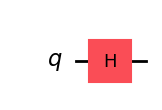

In [2]:
# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.id(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)

original_circuit.draw("mpl")

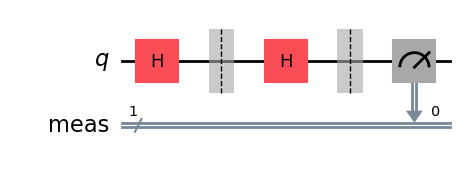

In [3]:
aux_circuits[0].draw('mpl')

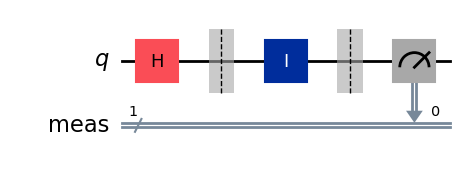

In [4]:
aux_circuits[1].draw('mpl')

In [5]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.result import QuasiDistribution
from qiskit.circuit.library import IGate, ZGate, XGate, YGate
import numpy as np

In [6]:
## SAMPLER
shots = 10000
sampler = StatevectorSampler()
job = sampler.run(aux_circuits, shots = shots)
data_pub = job.result()[1].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution({outcome: freq / shots for outcome, freq in counts.items()})

expvals = []
for pauli in H.paulis:
    val = 0
    
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    
    if str(pauli) == "X":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * quasi_dist.get(1)
        val += Lambda[1][0] * quasi_dist.get(0)
    
    if str(pauli) == "Y":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * 1.j * quasi_dist.get(1)
        val += Lambda[1][0] * -1.j * quasi_dist.get(0)

    if str(pauli) == "Z":
        Lambda = ZGate().to_matrix().real
        val += Lambda[0][0] * quasi_dist.get(0)
        val += Lambda[1][1] * quasi_dist.get(1)
    
    expvals.append(val)

print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")

## ESTIMATOR
observables = [
    *H.paulis,H
]  # Note: run for individual Paulis as well as full observable H

estimator = StatevectorEstimator()
job = estimator.run([(original_circuit, observables)])
estimator_expvals = job.result()[0].data.evs

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: -0.02640
  >> Total expected value: 2.02640
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


In [7]:
## SAMPLER
shots = 10000
sampler = StatevectorSampler()
job = sampler.run(aux_circuits, shots = shots)
data_pub = job.result()[1].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution({outcome: freq / shots for outcome, freq in counts.items()})

expvals = []
for pauli in H.paulis:
    val = 0
    
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    
    if str(pauli) == "X":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * quasi_dist.get(1)
        val += Lambda[1][0] * quasi_dist.get(0)
    
    if str(pauli) == "Y":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * 1.j * quasi_dist.get(1)
        val += Lambda[1][0] * -1.j * quasi_dist.get(0)

    if str(pauli) == "Z":
        Lambda = ZGate().to_matrix().real
        val += Lambda[0][0] * quasi_dist.get(0)
        val += Lambda[1][1] * quasi_dist.get(1)
    
    expvals.append(val)

print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")

## ESTIMATOR
observables = [
    *H.paulis,H
]  # Note: run for individual Paulis as well as full observable H

estimator = StatevectorEstimator()
job = estimator.run([(original_circuit, observables)])
estimator_expvals = job.result()[0].data.evs

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.01520
  >> Total expected value: 1.98480
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


In [8]:
def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

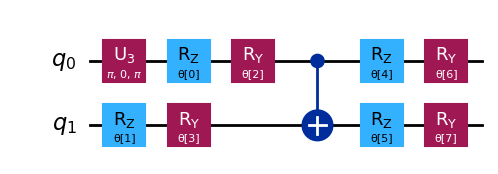

In [9]:
from qiskit.circuit.library import TwoLocal

observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
ansatz.decompose().draw('mpl')

In [10]:
estimator = StatevectorEstimator()
cost = cost_func_vqe(theta_list, ansatz, observable, estimator)
print(cost)

[-0.95625179]


In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorOptions, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Select the least busy backend:

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)
#Or get a specific backend:
#backend = service.backend("ibm_cusco")

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout = isa_ansatz.layout)


# Set estimator options
estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

# Open a Runtime session:

with Session(backend=backend) as session:
    estimator = Estimator(mode=session, options = estimator_options)
    cost = cost_func_vqe(theta_list, isa_ansatz, isa_observable, estimator)

session.close()
print(cost)

[-0.99929184]


Lets get back to the Max cut problem once again. This is a combinatorial optimization problem that involves dividing the vertices of a graph into two disjoint sets such that the number of edges between the two sets is maximized.

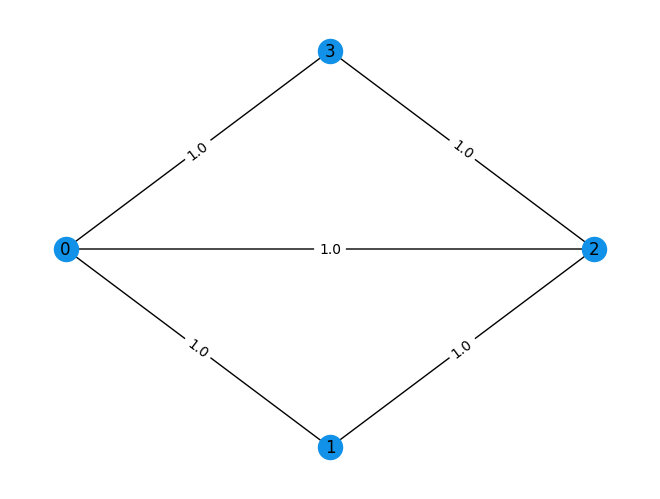

In [14]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

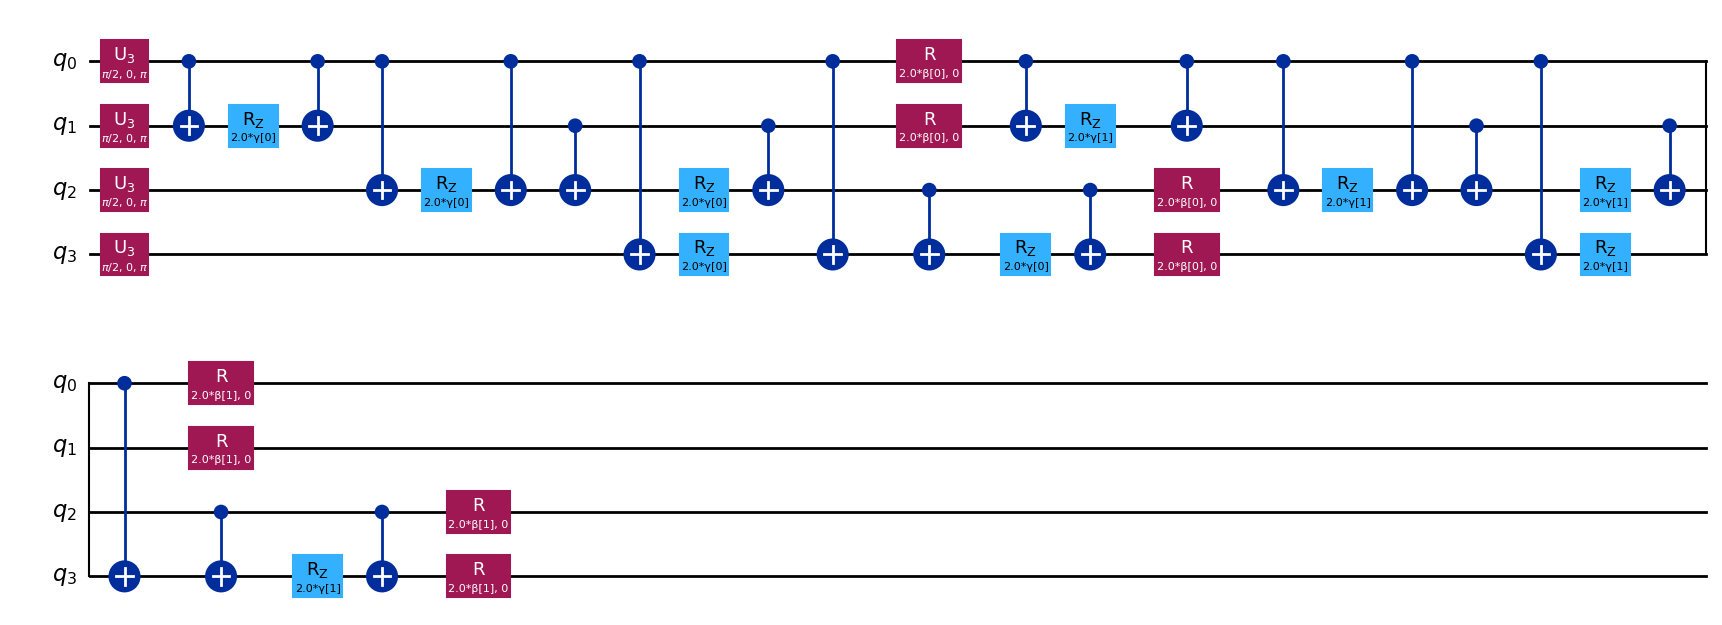

In [15]:
#QAOAAnsatz problem
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])


ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

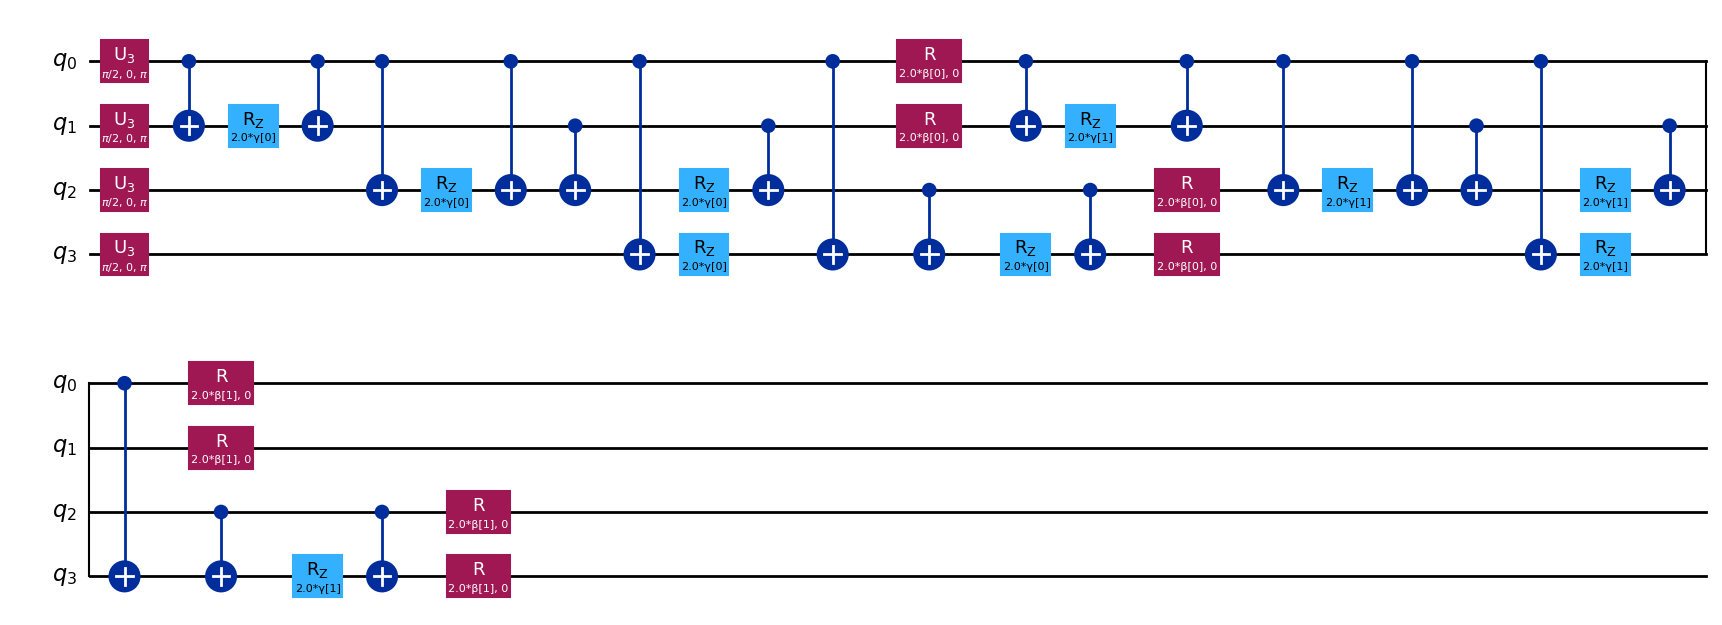

In [16]:
#Sum the weights and divide by 2
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])


ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

In [17]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [18]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

estimator = StatevectorEstimator()
cost = cost_func_vqe(x0, ansatz, hamiltonian, estimator)
print(cost)

1.4090344531019219


In [21]:
#Estimated usage: < 1 min, benchmarked at 6 seconds on ibm_osaka, 5-23-24
#Load some necessary packages:

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

#Select the least busy backend:

backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

#Or get a specific backend:
#backend = service.backend("ibm_cusco")

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_hamiltonian = hamiltonian.apply_layout(layout = isa_ansatz.layout)

# Set estimator options
estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

# Open a Runtime session:

with Session(backend=backend) as session:
    estimator = Estimator(mode=session, options = estimator_options)
    cost = cost_func_vqe(x0, isa_ansatz, isa_hamiltonian, estimator)

# Close session after done
session.close()
print(cost)

RuntimeJobFailureError: 'Unable to retrieve job result. Error code 1500; Internal error. -- Try again or contact support. -- https://ibm.biz/error_codes#1500'

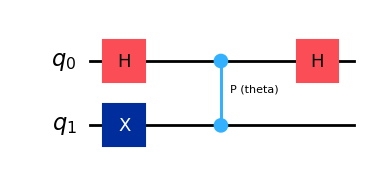

In [22]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

qc.draw("mpl")

In [23]:
## Setup phases
import numpy as np

phases = np.linspace(0, 2*np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

In [24]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

# get a real backend from the runtime service
service = QiskitRuntimeService()
backend = service.backend('ibm_sherbrooke')
 
# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)

In [25]:
#Import estimator and specify that we are using the simulated backend:

from qiskit_ibm_runtime import EstimatorV2 as Estimator
estimator = Estimator(mode = backend_sim)

circuit = qc

#Use a pass manager to transpile the circuit and observable for the backend being simulated.
#Start with no optimization:

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=0)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

noisy_exp_values = []
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
noisy_exp_values = cost[0]

#Repeat above steps, but now with optimization = 3:

exp_values_with_opt_es = []
pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=3)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
exp_values_with_opt_es = cost[0]

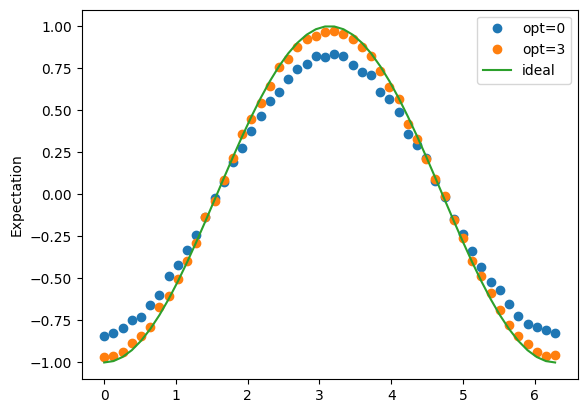

In [26]:
import matplotlib.pyplot as plt

plt.plot(phases, noisy_exp_values, "o", label="opt=0")
plt.plot(phases, exp_values_with_opt_es, "o", label="opt=3")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

In [27]:
# Estimated usage: 8 minutes, benchmarked on ibm_sherbrooke, 5-23-24

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Options, Session, EstimatorOptions, EstimatorV2 as Estimator

# We select the least busy backend

# Select the least busy backend
#backend = service.least_busy(
#    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
#)

# Or use a specific backend
backend = service.backend("ibm_cusco")

#Initialize some variables to save the results from different runs:

exp_values_with_em0_es = []
exp_values_with_em1_es = []
exp_values_with_em2_es = []

#Use a pass manager to optimize the circuit and observables for the backend chosen:

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

# Open a session and run with no error mitigation:

estimator_options = EstimatorOptions(
    resilience_level=0,
    default_shots = 10_000
)

with Session(backend=backend) as session:


    estimator = Estimator(mode=session, options = estimator_options)
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em0_es = cost[0]

# Open a session and run with resilience = 1:

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session, options = estimator_options)
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em1_es = cost[0]

# Open a session and run with resilience = 2:

estimator_options = EstimatorOptions(
    resilience_level=2,
    default_shots = 10_000
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session, options = estimator_options)

    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em2_es = cost[0]

QiskitBackendNotFoundError: 'No backend matches the criteria.'

In [28]:
import matplotlib.pyplot as plt

plt.plot(phases, exp_values_with_em0_es, "o", label="unmitigated")
plt.plot(phases, exp_values_with_em1_es, "o", label="resil = 1")
plt.plot(phases, exp_values_with_em2_es, "o", label="resil = 2")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

NameError: name 'exp_values_with_em0_es' is not defined